In [19]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
from utilities.postprocessing.utils import *
from imutils import rotate

In [2]:
%matplotlib notebook


In [3]:
def imshow(im):
    fig = plt.figure()
    plt.imshow(im)
    plt.show()

<IPython.core.display.Javascript object>


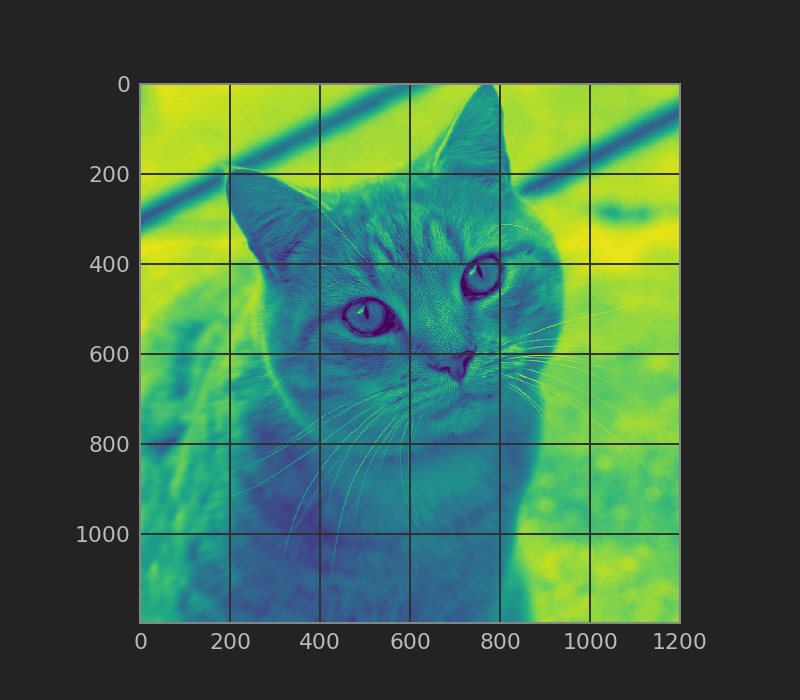

(1199, 1200)

In [22]:
hm = cv2.imread('/home/francesco/Pictures/cat.jpg')
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
imshow(hm)
hm.shape

In [35]:
class KrockPatchExtractStrategyNumpy(KrockPatchExtractStrategy):


    def __call__(self, hm, x, y, alpha, res=0.02, debug=False):
        max_advancement = self.max_advancement
        missing_krock_body = KrockDims.KROCK_SIZE - KrockDims.HEAD_OFFSET
        patch_size = (max_advancement + KrockDims.HEAD_OFFSET) / res * 2
        offset = (math.ceil((missing_krock_body - max_advancement) / res), 0)
        print(offset)
        patch_size = math.ceil(patch_size)
        half = ( patch_size//2)
        
        patch = hm[x - half  - offset[0] :x + half, 
                   y - half:y +half]
        
        return patch, None




In [36]:
??rotate

In [39]:
import cv2
im = cv2.imread('/media/francesco/saetta/krock-dataset/train/patches/0.66/bars1-1.0-0-7.png')

im.shape

(66, 76, 3)

<IPython.core.display.Javascript object>


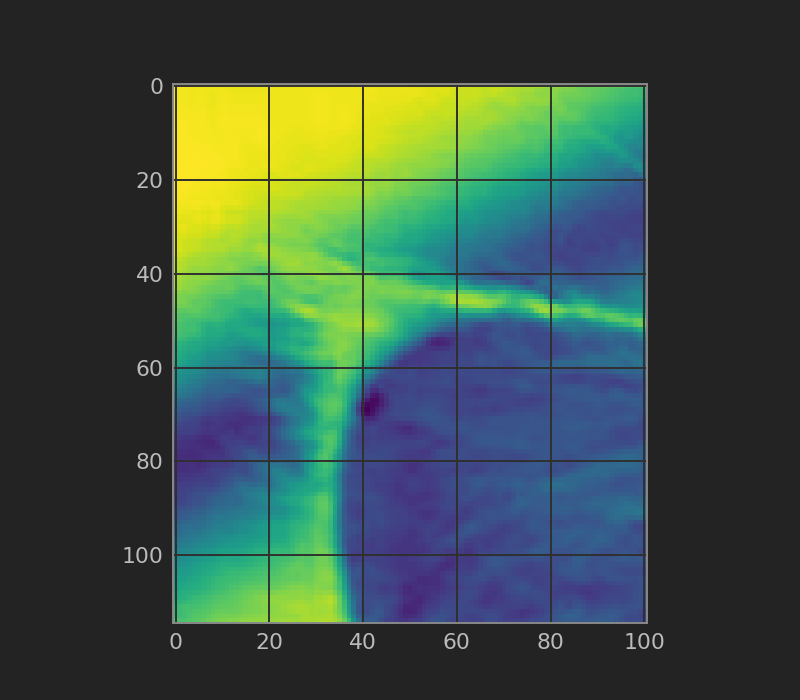

(115, 101)
(-14, 0)


<IPython.core.display.Javascript object>


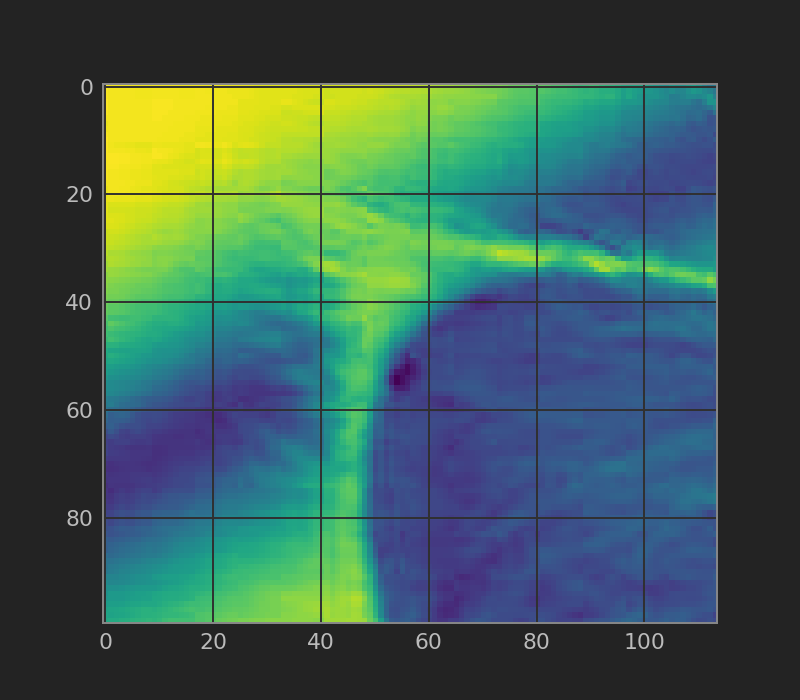

(100, 114)


In [37]:
patch_extract = KrockPatchExtractStrategy(1)
alpha = 0
im = patch_extract(hm, 200, 200, alpha)[0]
imshow(im)

print(im.shape)
patch_extract = KrockPatchExtractStrategyNumpy(1)
im = patch_extract(hm, 200, 200, 0)[0]
im = rotate(im, -alpha)
imshow(im)

print(im.shape)


In [ ]:
from utilities.postprocessing.utils import KrockPatchExtractStrategy

def hm_patch_generator(hm, step, alpha, max_advancement, res):
    patch_extract = KrockPatchExtractStrategy(max_advancement)

    h, w = hm.shape
    x = 0
    while x < w:
        y = 0
        while y < h:
            yield patch_extract(hm, x,y, alpha, res)[0]
            y += step
        x += step


In [ ]:
for im in hm_patch_generator(hm, 25, 0, 10, 0.02):
    
    if i % 10 == 0:   
        imshow(im)
